In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.signal import find_peaks
from scipy import stats
import matplotlib.pyplot as plt
import random
import os
from natsort import natsorted
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
from tqdm.notebook import tqdm
from scipy.stats import kruskal
import scikit_posthocs as sp

FOLDNAME="UniMiB_raw"

path  = os.path.join(os.path.curdir, FOLDNAME)
try:
    os.removedirs(os.path.join(path, ".ipynb_checkpoints"))
except:
    pass
FILES = natsorted(os.listdir(path))
N     = len(FILES)
print(N)

1980


In [2]:
def CI95(input_array):
    if type(input_array) == list:
        input_array = np.array(input_array)
    if len(input_array.shape) > 1:
        raise ValueError("Only 1-dimensional arrays can be passed to the function")

    n = len(input_array)
    z_score = 1.645  # This is true for a CI of 95%
    q = 0.5  # For the median
    lower_bound = int(np.round(n * q - z_score * np.sqrt(n * q * (1 - q))))
    upper_bound = int(np.round(n * q + z_score * np.sqrt(n * q * (1 - q))))
    
    sort_arr = np.sort(input_array)
    lower_bound = sort_arr[lower_bound]
    upper_bound = sort_arr[upper_bound]
    
    return [lower_bound, upper_bound]

In [3]:
def F1score(TARGET, RESULT):
    F1_scores = {}
    for i in range(17):
        F1_scores[i] = {"TP": 0, "FP": 0, "FN": 0}
    for R, T in zip(RESULT, TARGET):
        if R == T:
            F1_scores[R]["TP"] += 1
        else:
            F1_scores[R]["FP"] += 1
            F1_scores[T]["FN"] += 1

    all_F1 = 0.0
    for i in range(17):
        if F1_scores[i]["TP"] == 0 and F1_scores[i]["TP"] + F1_scores[i]["FN"] + F1_scores[i]["FP"] > 0:
            F1_scores[i]["F1score"] = 0.0
        elif F1_scores[i]["TP"] + F1_scores[i]["FN"] + F1_scores[i]["FP"] > 0:
            F1_scores[i]["Precision"] = F1_scores[i]["TP"] / (F1_scores[i]["TP"] + F1_scores[i]["FP"])
            F1_scores[i]["Recall"] = F1_scores[i]["TP"] / (F1_scores[i]["TP"] + F1_scores[i]["FN"])
            F1_scores[i]["F1score"] = 2 * F1_scores[i]["Precision"] * F1_scores[i]["Recall"] / (F1_scores[i]["Precision"] + F1_scores[i]["Recall"])
        else:
            F1_scores[i]["F1score"] = 1.0
        all_F1 += F1_scores[i]["F1score"]
    all_F1 /= 17
    return all_F1

### Settings for figures

In [4]:
SMALLER_SIZE = 14
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALLER_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

boxprops = dict(linestyle="-", linewidth=2, color="k")
medianprops = dict(linestyle="-", linewidth=4, color="k")
whiskerprops = dict(linestyle="-", linewidth=2, color="k")
capprops = dict(linestyle="-", linewidth=2, color="k")

### Here we train

In [5]:
# Train here
y = np.loadtxt("y_UniMiB_SHAR.csv").astype(int)
x_list = []
y_list = []
z_list = []
for file in range(0, N):     

    fileName= os.path.join(path, FILES[file])
    D = np.genfromtxt(fileName, delimiter=',')  # Data = [ X Y Z time]
    x_list.append(D[:, 0])
    y_list.append(D[:, 1])
    z_list.append(D[:, 2])
    
# Statistical Features on raw x, y and z in time domain
X = pd.DataFrame()

# mean
X['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X['x_maxmin_diff'] = X['x_max'] - X['x_min']
X['y_maxmin_diff'] = X['y_max'] - X['y_min']
X['z_maxmin_diff'] = X['z_max'] - X['z_min']

# median
X['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

In [6]:
# define the classifiers
svm_clf = SVC(probability=True)
rf_clf = RandomForestClassifier(n_estimators=100)
cat_clf = CatBoostClassifier(random_seed=89, verbose=False)


# set up k-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=89)

svm_scores = []
rf_scores = []
cat_scores = []
all_scores = []

svm_F1_scores = []
rf_F1_scores = []
cat_F1_scores = []
all_F1_scores = []

svm_conf_matrices = []
rf_conf_matrices = []
cat_conf_matrices = []
all_conf_matrices = []

svm_times = []
rf_times = []
cat_times = []

rf_importances = []
cat_importances = []

# perform k-fold cross-validation
for train_indices, test_indices in tqdm(skf.split(X, y), total=skf.get_n_splits(), desc="k-fold"):
    X_train = X.iloc[train_indices]
    y_train = y[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y[test_indices]
    
    # train and test the classifiers
    
    # SVM
    t0 = time.time()
    svm_clf.fit(X_train, y_train)
    svm_score = svm_clf.score(X_test, y_test)
    svm_pred = svm_clf.predict(X_test)
    svm_scores.append(svm_score)
    svm_F1_scores.append(F1score(y_test, svm_clf.predict(X_test)))
    svm_confidence = np.max(svm_clf.predict_proba(X_test), axis=1)
    t1 = time.time()
    t_svm = t1 - t0
    
    # Random Forest
    t0 = time.time()
    rf_clf.fit(X_train, y_train)
    rf_score = rf_clf.score(X_test, y_test)
    rf_pred = rf_clf.predict(X_test)
    rf_scores.append(rf_score)
    rf_F1_scores.append(F1score(y_test, rf_clf.predict(X_test)))
    rf_confidence = np.max(rf_clf.predict_proba(X_test), axis=1)
    t1 = time.time()
    t_rf = t1 - t0
    
    # Catboost
    t0 = time.time()
    cat_clf.fit(X_train, y_train)
    cat_score = cat_clf.score(X_test, y_test) 
    cat_pred = np.concatenate(cat_clf.predict(X_test))
    cat_scores.append(cat_score)
    cat_F1_scores.append(F1score(y_test, np.concatenate(cat_clf.predict(X_test))))
    cat_confidence = np.max(cat_clf.predict_proba(X_test), axis=1)
    t1 = time.time()
    t_cat = t1 - t0
    
    svm_times.append(t_svm)
    rf_times.append(t_rf)
    cat_times.append(t_cat)
    
    rf_importances.append(rf_clf.feature_importances_)
    cat_importances.append(cat_clf.feature_importances_)
    
    
    svm_conf = confusion_matrix(y_test, svm_pred, normalize="true")
    svm_conf_matrices.append(svm_conf)
    rf_conf = confusion_matrix(y_test, rf_pred, normalize="true")
    rf_conf_matrices.append(rf_conf)
    cat_conf = confusion_matrix(y_test, cat_pred, normalize="true")
    cat_conf_matrices.append(cat_conf)

k-fold:   0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
# print the average accuracy across all folds for each classifier
print(f'SVM classifier accuracy: {np.mean(svm_scores):.2f} ± {np.std(svm_scores):.2f}; {np.median(svm_scores):.2f} [{CI95(svm_scores)[0]:.2f} {CI95(svm_scores)[1]:.2f}]')
print(f'Random Forest classifier accuracy: {np.mean(rf_scores):.2f} ± {np.std(rf_scores):.2f}; {np.median(rf_scores):.2f} [{CI95(rf_scores)[0]:.2f} {CI95(rf_scores)[1]:.2f}]')
print(f'Catboost classifier accuracy: {np.mean(cat_scores):.2f} ± {np.std(cat_scores):.2f}; {np.median(cat_scores):.2f} [{CI95(cat_scores)[0]:.2f} {CI95(cat_scores)[1]:.2f}]')
print()

print(f'SVM F1 score: {np.mean(svm_F1_scores):.2f} ± {np.std(svm_F1_scores):.2f}; {np.median(svm_F1_scores):.2f} [{CI95(svm_F1_scores)[0]:.2f} {CI95(svm_F1_scores)[1]:.2f}]')
print(f'Random Forest F1 score: {np.mean(rf_F1_scores):.2f} ± {np.std(rf_F1_scores):.2f}; {np.median(rf_F1_scores):.2f} [{CI95(rf_F1_scores)[0]:.2f} {CI95(rf_F1_scores)[1]:.2f}]')
print(f'Catboost F1 score: {np.mean(cat_F1_scores):.2f} ± {np.std(cat_F1_scores):.2f}; {np.median(cat_F1_scores):.2f} [{CI95(cat_F1_scores)[0]:.2f} {CI95(cat_F1_scores)[1]:.2f}]')
print()

print(f'SVM times [s]: {np.mean(svm_times):.2f} ± {np.std(svm_times):.2f}; {np.median(svm_times):.2f} [{CI95(svm_times)[0]:.2f} {CI95(svm_times)[1]:.2f}]')
print(f'Random Forest times [s]: {np.mean(rf_times):.2f} ± {np.std(rf_times):.2f}; {np.median(rf_times):.2f} [{CI95(rf_times)[0]:.2f} {CI95(rf_times)[1]:.2f}]')
print(f'Catboost times [s]: {np.mean(cat_times):.2f} ± {np.std(cat_times):.2f}; {np.median(cat_times):.2f} [{CI95(cat_times)[0]:.2f} {CI95(cat_times)[1]:.2f}]')

SVM classifier accuracy: 0.40 ± 0.03; 0.40 [0.39 0.43]
Random Forest classifier accuracy: 0.60 ± 0.03; 0.60 [0.57 0.63]
Catboost classifier accuracy: 0.62 ± 0.04; 0.62 [0.58 0.66]

SVM F1 score: 0.38 ± 0.04; 0.38 [0.36 0.42]
Random Forest F1 score: 0.61 ± 0.04; 0.59 [0.58 0.64]
Catboost F1 score: 0.63 ± 0.05; 0.66 [0.59 0.69]

SVM times [s]: 1.40 ± 0.08; 1.41 [1.32 1.49]
Random Forest times [s]: 1.05 ± 0.08; 1.02 [1.00 1.14]
Catboost times [s]: 15.84 ± 1.98; 14.95 [14.59 19.15]


In [8]:
# Perform Kruskal-Wallis test
kw_statistic, p_value = kruskal(svm_scores, rf_scores, cat_scores)
print("Accuracy Kruskal-Wallis test p-value:", p_value)
# Perform post hoc analysis
display(sp.posthoc_dunn([svm_scores, rf_scores, cat_scores], p_adjust = 'bonferroni'))

kw_statistic, p_value = kruskal(svm_F1_scores, rf_F1_scores, cat_F1_scores)
print("F1-score Kruskal-Wallis test p-value:", p_value)
# Perform post hoc analysis
display(sp.posthoc_dunn([svm_F1_scores, rf_F1_scores, cat_F1_scores], p_adjust = 'bonferroni'))

kw_statistic, p_value = kruskal(svm_times, rf_times, cat_times)
print("Times Kruskal-Wallis test p-value:", p_value)
# Perform post hoc analysis
display(sp.posthoc_dunn([svm_times, rf_times, cat_times], p_adjust = 'bonferroni'))

Accuracy Kruskal-Wallis test p-value: 4.34303694666386e-05


,1,2,3
1,1.000000,0.00207,0.000069
2,0.002070,1.00000,1.000000
3,0.000069,1.00000,1.000000


F1-score Kruskal-Wallis test p-value: 4.68883208700425e-05


,1,2,3
1,1.000000,0.001817,0.000083
2,0.001817,1.000000,1.000000
3,0.000083,1.000000,1.000000


Times Kruskal-Wallis test p-value: 2.49000508218493e-06


,1,2,3
1,1.000000,0.033255,0.033255
2,0.033255,1.000000,0.000001
3,0.033255,0.000001,1.000000


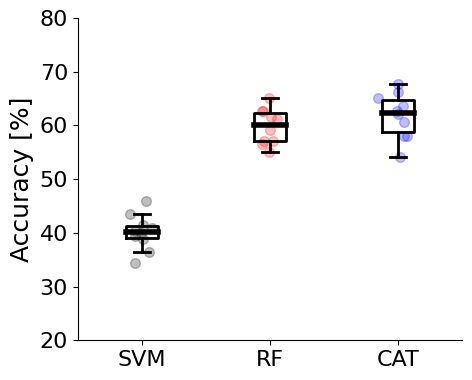

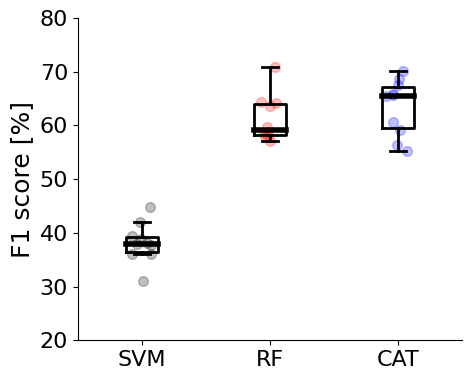

In [13]:
scores = {"SVM": svm_scores, "RF": rf_scores, "CAT": cat_scores}
F1_scores = {"SVM": svm_F1_scores, "RF": rf_F1_scores, "CAT": cat_F1_scores}
markers = ["o", "o", "o", "o"]
colors = ["black", "red", "blue"]

fig = plt.figure(figsize=(5, 4))
for m, model in enumerate(["SVM", "RF", "CAT"]):
    accuracies = np.array(scores[model]) * 100.0
    plt.plot(np.random.normal(m, 0.05, len(accuracies)), accuracies, color=colors[m], alpha=0.25, ms=7, marker=markers[m], linestyle="None", label=model)
    
    dataframe = pd.DataFrame(accuracies)
    dataframe.boxplot(positions=[m], patch_artist=False, widths=(0.25),
                      boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops,
                      showfliers=False, grid=False, ax=plt.gca())

plt.ylabel("Accuracy [%]")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.box("off")
plt.xticks(range(3), labels=["SVM", "RF", "CAT"])
plt.tight_layout()
plt.ylim(20, 80)

plt.savefig("acc_superreducedfeatures_UniMiB.png", dpi=900)

fig = plt.figure(figsize=(5, 4))
for m, model in enumerate(["SVM", "RF", "CAT"]):
    accuracies = np.array(F1_scores[model]) * 100.0
    plt.plot(np.random.normal(m, 0.05, len(accuracies)), accuracies, color=colors[m], alpha=0.25, ms=7, marker=markers[m], linestyle="None", label=model)
    
    dataframe = pd.DataFrame(accuracies)
    dataframe.boxplot(positions=[m], patch_artist=False, widths=(0.25),
                      boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops,
                      showfliers=False, grid=False, ax=plt.gca())

plt.ylabel("F1 score [%]")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.box("off")
plt.xticks(range(3), labels=["SVM", "RF", "CAT"])
plt.tight_layout()
plt.ylim(20, 80)
plt.savefig("F1_superreducedfeatures_UniMiB.png", dpi=900)

plt.show()

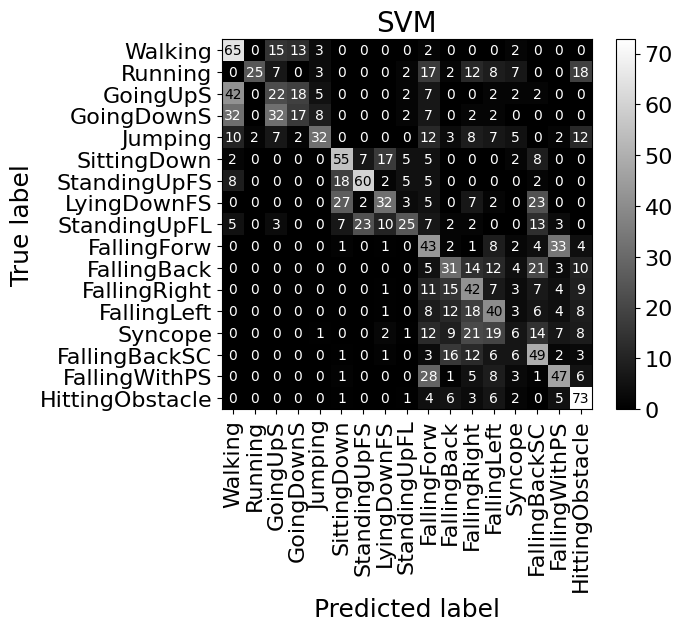

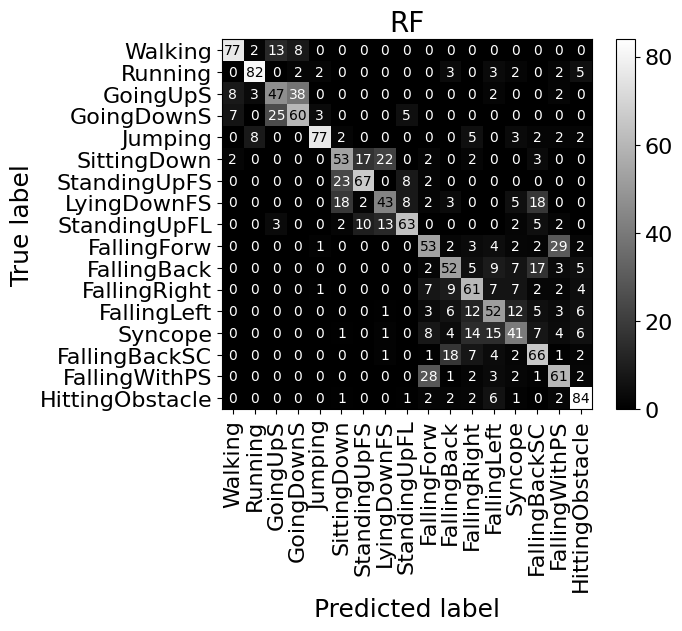

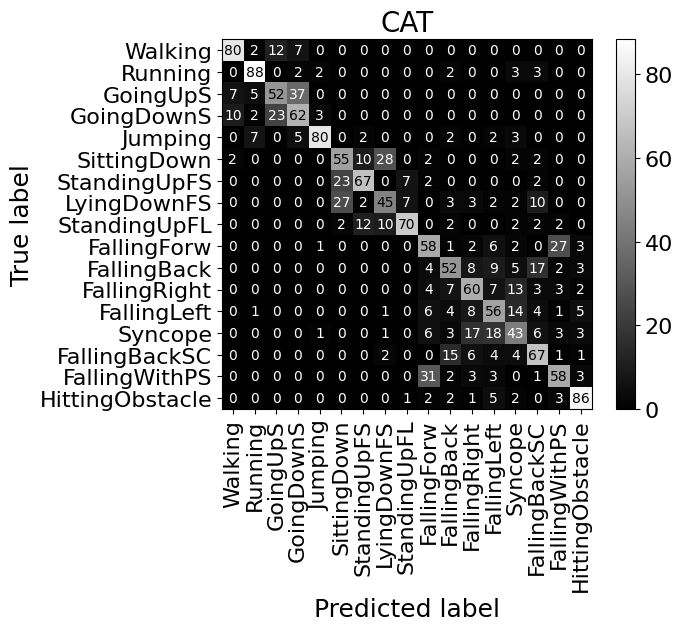

In [10]:
classes = ['Walking','Running','GoingUpS','GoingDownS','Jumping','SittingDown','StandingUpFS','LyingDownFS','StandingUpFL','FallingForw','FallingBack','FallingRight','FallingLeft','Syncope','FallingBackSC','FallingWithPS','HittingObstacle']

disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(svm_conf_matrices, axis=0)*100, display_labels=classes)
disp.plot(cmap="gray", values_format=".0f", xticks_rotation=90)
for labels in disp.text_.ravel():
    labels.set_fontsize(10)
plt.title("SVM")
plt.savefig("Confusion_SVM_superreducedfeatures_UniMiB.png", dpi=900)
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(rf_conf_matrices, axis=0)*100, display_labels=classes)
disp.plot(cmap="gray", values_format=".0f", xticks_rotation=90)
for labels in disp.text_.ravel():
    labels.set_fontsize(10)
plt.title("RF")
plt.savefig("Confusion_RF_superreducedfeatures_UniMiB.png", dpi=900)
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=np.mean(cat_conf_matrices, axis=0)*100, display_labels=classes)
disp.plot(cmap="gray", values_format=".0f", xticks_rotation=90)
for labels in disp.text_.ravel():
    labels.set_fontsize(10)
plt.title("CAT")
plt.savefig("Confusion_CAT_superreducedfeatures_UniMiB.png", dpi=900)
plt.show()

In [11]:
rf_feature_importances = np.mean(rf_importances, axis=0) * 100.0
cat_feature_importances = np.mean(cat_importances, axis=0)

# Create a DataFrame to display feature names and their corresponding importance scores
rf_feature_importance_df = pd.DataFrame({'Feature': list(X.columns), 'Importance': rf_feature_importances})

# Sort the features based on importance in descending order
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)


# Create a DataFrame to display feature names and their corresponding importance scores
cat_feature_importance_df = pd.DataFrame({'Feature': list(X.columns), 'Importance': cat_feature_importances})

# Sort the features based on importance in descending order
cat_feature_importance_df = cat_feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importance
print(rf_feature_importance_df)
print(cat_feature_importance_df)

# Check if there is a correlation between importances in RF and CAT
print(np.corrcoef(rf_feature_importances, cat_feature_importances)[0, 1])

          Feature  Importance
5           z_std    5.049331
2          z_mean    4.833924
4           y_std    4.777709
17  z_maxmin_diff    4.455839
15  x_maxmin_diff    4.363376
7           y_aad    4.357907
25          y_IQR    4.285125
1          y_mean    4.283217
16  y_maxmin_diff    4.224822
14          z_max    4.109113
3           x_std    4.104530
20       z_median    3.806910
22          y_mad    3.616327
8           z_aad    3.596968
13          y_max    3.451766
6           x_aad    3.439258
10          y_min    3.359042
23          z_mad    3.256344
11          z_min    3.223519
26          z_IQR    3.108189
19       y_median    3.086510
0          x_mean    3.052649
9           x_min    3.042568
24          x_IQR    3.035568
21          x_mad    2.832126
18       x_median    2.769146
12          x_max    2.478215
          Feature  Importance
5           z_std    6.077647
16  y_maxmin_diff    4.907477
4           y_std    4.760153
17  z_maxmin_diff    4.741978
22        

In [12]:
rf_x_imp = 0
rf_y_imp = 0
rf_z_imp = 0
rf_fft_imp = 0

for feat, imp in zip(rf_feature_importance_df["Feature"], rf_feature_importance_df["Importance"]):
    if feat[0] == "x":
        rf_x_imp += imp
    elif feat[0] == "y":
        rf_y_imp += imp
    elif feat[0] == "z":
        rf_z_imp += imp
    if feat[-3:] == "fft":
        rf_fft_imp += imp

cat_x_imp = 0
cat_y_imp = 0
cat_z_imp = 0
cat_fft_imp = 0

for feat, imp in zip(cat_feature_importance_df["Feature"], cat_feature_importance_df["Importance"]):
    if feat[0] == "x":
        cat_x_imp += imp
    elif feat[0] == "y":
        cat_y_imp += imp
    elif feat[0] == "z":
        cat_z_imp += imp
    if feat[-3:] == "fft":
        cat_fft_imp += imp
        
print(rf_x_imp, rf_y_imp, rf_z_imp, rf_fft_imp)
print(cat_x_imp, cat_y_imp, cat_z_imp, cat_fft_imp)

29.11743608366089 35.442427085109486 35.44013683122963 0
28.332416647848916 36.119828644484485 35.5477547076666 0
